In [5]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)


In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

emails=pd.read_csv('emails.csv')
ham = emails[emails['spam'] == 0][1000:1950][['email', 'spam']]
spam = emails[emails['spam'] == 1][400:450][['email', 'spam']]
emails = pd.concat([ham, spam]).reset_index(drop=True)
emails.to_csv('selected_emails.csv')

In [17]:
#HIDDEN (from proj 2, simply for the purpose of generating the feature matrix X for the model training)

def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.array([texts.str.contains(word) * 1 for word in words]).T

    # YOUR CODE HERE
    return indicator_array

## Evaluating Classification Models

In this section, we examine more metrics to evaluate the performance of trained classification models.

Suppose we have a dataset of 1000 emails that are labeled as spam or ham and our goal is to build a classifier that distinguishes future spam emails from ham emails. The data is contained in the `emails` DataFrame displayed below:

In [18]:
emails

,email,spam
0,"\n Hi Folks,\n \n I've been trying to set a bu...",0
1,Hah. I guess she doesn't want everyone to kno...,0
2,This article from NYTimes.com \n has been sent...,0
...,...,...
997,"<html>\n <head>\n <meta http-equiv=""Conten...",1
998,<html>\n <head>\n </head>\n <body>\n \n <cente...,1
999,"\n <html>\n \n <head>\n <meta http-equiv=3D""Co...",1


Each row contains the body of an email and a `spam` column, which is `0` if the email is ham or `1` if it is spam.

Suppose we have a list of words `words_list` that we believe are common in spam emails: "please", "click", "money", and "business". We transform each email into a feature vector by setting the vector's $i$th entry to 1 if the $i$th word in `words_list` is contained in the email body and 0 if it isn't. For example, using our four chosen words and the email body "please respond by tomorrow", the feature vector would be $[1, 0, 0, 0]$. This procedure generates the `1000 X 4` feature matrix $X$.

The following code trains the classifier `words_list_model`. The conversion of the raw email text to the feature matrix $X$ and the train-test split are omitted for brevity.

In [13]:
words = ['please', 'click', 'money', 'business']

# HIDDEN

X = pd.DataFrame(words_in_texts(words, emails['email'].str.lower())).as_matrix()
y = emails['spam'].as_matrix()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=41
)

# SHOW

#Fit the model
words_list_model = LogisticRegression(fit_intercept=True)
words_list_model.fit(X_train, y_train)

print(f'Test set accuracy: {words_list_model.score(X_test, y_test)}')

Test set accuracy: 0.944


Using just the occurrence of four words, we have built a model that accurately classifies about 94% of the emails in the test set, which at first glance is a good result. However, if we take a closer look at our data we realize that our classifier isn't performing as well as we thought. 

The accuracy we computed is the proportion of predictions that the model correctly classified. The fact that the accuracy is high implies that most of the model's classifications are true positives and true negatives, which occur when the model correctly labels the positive class (spam) and negative class (ham) respectively. On the other hand, there are two types of errors a model can make:

* False positive: the model assigns a data point to the positive class (spam) whereas it actually belonged in the negative class (ham). In our case, a false positive means that a ham email gets flagged as spam and filtered out of the inbox.
* False negative: the model assigns a data point to the negative class (ham) whereas it actually belonged in the positive class (spam). In our case, a false negative means that a spam email gets mislabelled as ham and ends up in the inbox. 

We can assess the number of errors relative to correct classifications by building a **confusion matrix**, which contains the model predictions on one axis and the actual labels on the other. 

Confusion matrix, without normalization
[[710   4]
 [ 33   3]]


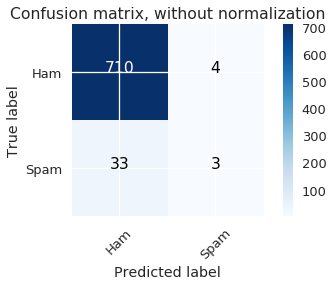

In [14]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_train, words_list_model.predict(X_train))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Ham', 'Spam']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')


See [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) for more on scikit-learn's confusion matrix generator.

Adding together the number of true positives and false negatives, we know the training dataset contains 36 spam emails, but the model only detected 3 of them. Despite its high accuracy, the model identified $\frac{1}{12}$ of spam emails, which is quite a poor performance. 

What if we used a classifier `ham_only` that simply labeled every email as ham? We can calculate its accuracy by knowing the number of ham emails in the dataset: $$ \text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN} = \frac{0 + 714}{0 + 0 + 714 + 36} = .95$$


This model, which is essentially useless as a classifier since it assigns all data to the same class, surprisingly achieves a better accuracy than our EDA-driven model. Clearly accuracy alone can be a misleading indicator of model performance. This is especially characteristic of **class-imbalanced datasets**, in which a vast majority of labels belong in one class over the other. In this case, most of our emails are ham. The confusion matrix shows that `words_list_model` had many more false negatives than true positives, which implies that it didn't have enough features to reliably identify spam, but because the dataset is predominantly ham, it had a deceptively high accuracy. Another common example of class imbalance is disease detection when the frequency of the disease in a population is low.

We now turn to precision and recall, two metrics that are better suited for evaluating class-imbalanced datasets.

### Precision

**Precision** (also called **positive predictive value**) measures the proportion of positively classified data that are actually positive. 

$$ \text{Precision} = \frac{TP}{TP + FP} $$ 

A model with high precision accurately classifies data that truly has positive labels, whereas a model with low precision incorrectly labels truly negative data as positive with high frequency (many false positives).

The precision of `words_list_model` is $ \frac{3}{3 + 4} \approx .43 $, whereas the precision of `ham_only` is 0 (do you see why?). This validates our expectation that `words_list_model` is a better classifier than `ham_only`, but there is still significant room to improve it.

See [here]() for scikit-learn's precision function.

### Recall

**Recall** (also called **sensitivity**) measures the proportion of actual positive data that is classified as positive.

$$ \text{Recall} = \frac{TP}{TP + FN} $$

A model with high recall accurately recognizes aspects of positive data, whereas a model with low recall isn't sensitive enough to what distinguishes positive from negative data, and as a result leads to ample false negatives.

The recall of `words_list_model` is $ \frac{3}{3 + 33} \approx .083$, whereas the recall of `ham_only` is 0 (do you see why?). This is further confirmation that `ham_only` is useless; however the abysmally low recall of `words_list_model` is a strong indication that we need to do much more EDA and feature engineering to improve the model.

See [here]() for scikit-learn's recall function.

### Precision-Recall Curve

Both precision and recall are needed to thoroughly evaluate a model. Although the goal is to maximize both metrics, there is a tradeoff between increasing precision and increasing recall. Generally, increasing precision leads to a decrease in recall and vice versa (though there may be some cases where they move in the same direction). For instance, reducing the number of false negatives can increase false positives on data for which the model is less certain of its classification.

The **classification threshold** is a value that determines what class a data point is assigned to; points that fall on opposite sides of the threshold are labeled with different classes. Recall that logistic regression outputs a probability that the data point belongs to the positive class. If the probability output on $x_1$ is .90 and the output on $x_2$ is .1, then we can be fairly confident that $x_1$ is spam and $x_2$ is ham. However, if the probability associated with $x_3$ is around .55, there is greater uncertainty about the correct class. If the classification threshold is .50, $x_3$ is labeled as spam, but if the threshold is .60, $x_3$ is labeled as ham. Depending on the classification problem, false positives and false negatives may have different importance. Set the classification threshold based on which error type you want to minimize: minimizing false positives maximizes precision and minimizing false negatives maximizes recall. For email classification, false positives result in important emails being filtered out, so they are worse than false negatives, in which a spam email winds up in the inbox. In medical settings, however, false negatives in a diagnostic test can be much more consequential than false positives.

A **precision-recall curve** plots the precision and recall at all classification thresholds. A point $(r, p)$ on the curve represents the recall and precision associated with a specific threshold value. The precision-recall curve for `words_list_model` is shown below:

array([ 0.02,  0.03,  0.05,  0.05,  0.06,  0.07,  0.11,  0.13,  0.14,
        0.17,  0.24,  0.26,  0.3 ,  0.33,  0.48,  0.56])

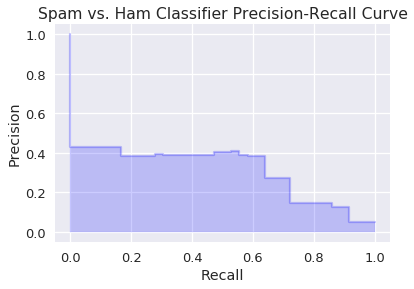

In [16]:
from sklearn.metrics import precision_recall_curve


probabilities = words_list_model.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, probabilities)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Spam vs. Ham Classifier Precision-Recall Curve')

See [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve) for scikit-learn's precision-recall function.

The **Area Under the Curve (AUC)** is a single number performance summary of the classifier. A large AUC means that the model has both high precision and recall, which implies that it has few false postivives and false negatives. The AUC for `words_list_model` is:

In [20]:
# from sklearn import metrics
# metrics.auc(precision, recall)

Depending on whether we value high precision or recall, we can pick a point on the precision-recall curve and use its associated threshold value for our final model. Most importantly, we use the curve to evaluate the performance of the model and whether or not to continue EDA and feature selection to improve it, as would be beneficial in the case of `words_list_model`.

### Summary

*In progress: depends on approval of the material covered so far.*